In [1]:
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import regularizers, optimizers
from livelossplot import PlotLossesKeras
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from PIL import ImageFile, Image


In [2]:
DATASET_PATH = "MAFood121\\images\\"
METADATA_PATH = "MAFood121\\metadata_win.csv"
IMAGE_PATH_KEY = "image_path"
LABELS_PATH_KEY = "label"
MODEL_PATH = "food-id-red22.h5"
IMAGE_SIZE = 224
BATCH_SIZE = 32
RANDOM_SEED = 115
EPOCHS = 50
TESTING_SIZE = 500
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 239200489

In [3]:
# Loading metadata and splitting into training/validation and testing sets
df = pd.read_csv(METADATA_PATH)

training_and_validation_size = df.shape[0] - TESTING_SIZE

training_df = df[:training_and_validation_size]
testing_df = df[training_and_validation_size:]

training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))
training_df

<ipython-input-3-9f420f2a59a6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[LABELS_PATH_KEY] = training_df[LABELS_PATH_KEY].apply(lambda x:literal_eval(x))


,image_path,label
0,hunkar_begendi\240.jpg,[hunkar_begendi]
1,hunkar_begendi\21.jpg,[hunkar_begendi]
2,naan\49_1.jpg,[naan]
3,ravioli\2725271.jpg,[ravioli]
4,caprese_salad\2358715.jpg,[caprese_salad]
...,...,...
20670,souvlaki\85_2.jpg,[souvlaki]
20671,breakfast_burrito\805523.jpg,[breakfast_burrito]
20672,nachos\500252.jpg,[nachos]
20673,omelette\800743.jpg,[omelette]


In [4]:
# Getting labels
all_labels = [] 

for tags in training_df[LABELS_PATH_KEY].values.tolist():
    for tag in tags:
        all_labels.append(tag)
        
unique_labels = list(np.unique(all_labels))

In [5]:
training_data_generator = ImageDataGenerator(rotation_range=15,
                                             zoom_range=0.1,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1,
                                             shear_range=0.1,
                                             horizontal_flip=False,
                                             fill_mode="nearest",
                                             validation_split=VALIDATION_SPLIT,
                                             preprocessing_function=preprocess_input)

training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=LABELS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 subset="training")

validation_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=LABELS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   subset="validation")


Found 18608 validated image filenames belonging to 121 classes.
Found 2067 validated image filenames belonging to 121 classes.


In [6]:
def model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(BatchNormalization())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.3))
        model.add(Dropout(.5))
        #model.add(Dense(256))
        #model.add(LeakyReLU(alpha=0.3))
        #model.add(Dropout(.5))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(1024, activation='relu'))
        #model.add(Dense(512, activation='relu'))
        
        model.add(Dense(len(unique_labels), activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(lr=LEARNING_RATE, decay=0),
                      metrics=["accuracy"])
        return model

    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)


model = model()

In [7]:
# Setting class weights to handle imbalanced data
'''
class_weights = class_weight.compute_class_weight('balanced',
                                                  unique_labels,
                                                  all_labels)

'''
#class_weights = dict(enumerate(class_weights))

"\nclass_weights = class_weight.compute_class_weight('balanced',\n                                                  unique_labels,\n                                                  all_labels)\n\n"

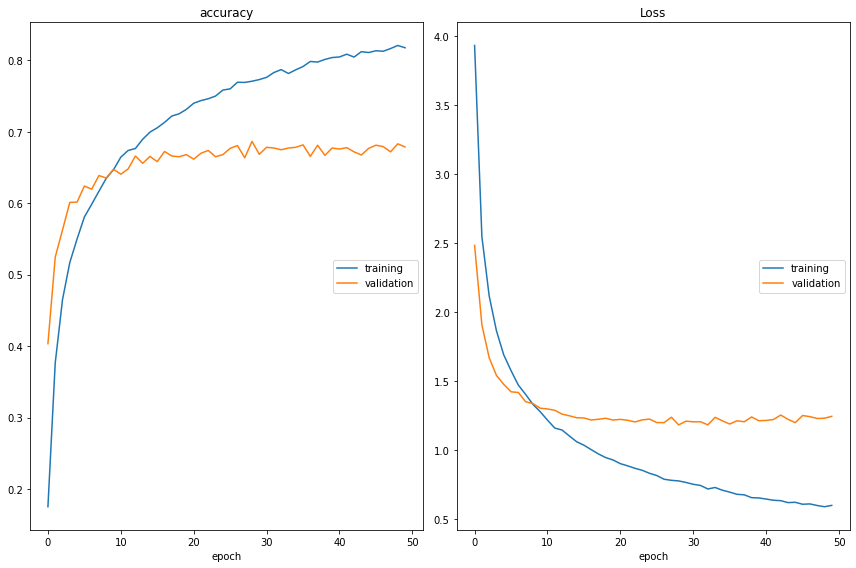

accuracy
	training         	 (min:    0.175, max:    0.821, cur:    0.818)
	validation       	 (min:    0.403, max:    0.687, cur:    0.679)
Loss
	training         	 (min:    0.589, max:    3.932, cur:    0.598)
	validation       	 (min:    1.182, max:    2.482, cur:    1.244)

Epoch 00050: val_accuracy did not improve from 0.68652


In [8]:
# Training
model.fit_generator(generator=training_generator,
                    #class_weight=class_weights,
                    steps_per_epoch=training_generator.n // training_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // validation_generator.batch_size,
                    callbacks=[PlotLossesKeras(), 
                               ModelCheckpoint(MODEL_PATH,
                                               monitor='val_accuracy',
                                               mode='max',
                                               save_best_only=True,
                                               verbose=1)],
                    epochs=EPOCHS)
model = load_model(MODEL_PATH)

In [9]:
# Testing
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               batch_size=1,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode=None,
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))
predictions = model.predict_generator(testing_generator,
                                      steps=testing_generator.n,
                                      verbose=1)

Found 500 validated image filenames.


c:\users\eric_\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


500/500 [==============================] - 8s 15ms/step


In [10]:
for prediction in predictions:
    print(prediction)

[2.02324245e-05 6.89830957e-03 3.55786702e-04 1.14668928e-05
 3.33146613e-06 6.90021040e-03 2.82542348e-01 1.63428613e-05
 3.39394660e-07 1.69688587e-06 1.62514203e-04 4.76880036e-02
 1.04519881e-04 1.07672822e-03 9.01887310e-04 4.67231468e-04
 1.94526394e-03 1.15169014e-03 2.58217216e-01 9.41907820e-06
 4.02839396e-05 2.55802061e-05 2.82816472e-05 1.69611259e-04
 2.36410433e-05 3.61826619e-06 2.64803995e-04 4.16483526e-05
 4.72002954e-04 2.64881440e-02 1.40869978e-03 1.01051235e-04
 5.69859731e-05 1.07270585e-04 9.96889721e-05 1.76460102e-01
 2.09332629e-05 1.37600100e-05 3.48386983e-03 3.01095936e-02
 9.64444876e-03 7.77938985e-04 5.55739086e-03 2.93515632e-06
 3.60049421e-06 3.88500484e-05 1.96562314e-06 1.54090696e-03
 8.89437069e-06 1.59562896e-05 1.99226633e-05 3.60012891e-05
 2.15569185e-06 4.28830504e-07 4.20547440e-05 1.97395275e-04
 3.73397525e-05 1.29660020e-05 8.71226166e-06 3.21255857e-03
 1.71681386e-04 3.22053347e-05 1.06842036e-03 8.07088800e-05
 2.00384008e-07 1.449581

 3.61550832e-03]
[3.77978943e-03 1.05130748e-05 3.19576259e-08 5.41072385e-03
 1.56118205e-07 2.03167673e-07 7.84421263e-06 4.30166119e-06
 6.65089028e-05 9.74740148e-01 1.22224756e-05 5.37302924e-07
 3.80462552e-06 4.68640610e-06 4.66451056e-05 4.58671893e-05
 3.82448420e-08 9.10441522e-05 8.50186098e-06 5.24669944e-04
 3.65442465e-05 2.32439163e-07 2.39216479e-06 2.98116156e-05
 3.63788172e-06 2.11799693e-06 3.97900876e-04 1.44941252e-04
 5.24047846e-06 1.16624846e-03 1.01377755e-05 1.03859179e-07
 1.27923570e-03 3.24532302e-05 9.48406450e-05 2.45569413e-06
 4.34088724e-05 1.96698602e-05 3.66200911e-05 1.84382159e-07
 1.91881483e-07 1.28729619e-06 1.99948245e-05 4.38870842e-08
 3.13073383e-06 3.02491435e-06 2.21067201e-03 2.77173440e-05
 4.69900613e-07 1.63897681e-07 2.68185568e-06 1.43607176e-04
 2.77735846e-04 1.15233255e-04 1.17714130e-07 9.05285706e-04
 2.79140022e-06 2.50474586e-05 8.05376203e-06 1.19980962e-06
 4.05816645e-05 1.62260321e-07 7.05755610e-07 5.33707578e-07
 4.7519

 2.4729372e-06]
[5.12764200e-05 1.60577736e-04 4.62269190e-06 1.84963858e-06
 1.10759558e-02 9.25078155e-07 2.27664085e-03 1.58939758e-04
 1.17643704e-05 2.61426317e-06 7.91711936e-05 1.40440052e-05
 3.27528309e-04 1.60233845e-04 7.06555875e-05 8.23737064e-04
 9.97563984e-06 1.25212083e-03 4.10780558e-05 1.19068600e-05
 5.98405139e-04 1.11202113e-04 4.54443361e-05 2.20466376e-04
 3.24037217e-07 1.55671496e-05 5.20497179e-06 2.77412310e-05
 1.26133364e-05 3.50268238e-04 1.58489555e-01 1.69364437e-02
 2.66365332e-05 1.84466742e-04 2.64886708e-04 3.53234005e-04
 1.24288758e-03 9.07571448e-05 4.06938343e-05 2.43545568e-04
 3.30924377e-04 6.76668060e-05 8.65265247e-05 8.07529489e-07
 8.45481845e-05 8.24567833e-05 7.13798954e-06 2.92432414e-05
 1.42188646e-05 5.40542569e-05 5.38994616e-04 2.06266918e-06
 3.00815918e-05 4.30491455e-05 1.85563345e-04 1.50908105e-04
 1.49465441e-05 9.25722816e-06 3.86966363e-04 6.21902349e-04
 1.52602675e-04 5.58319834e-06 2.56239236e-05 2.07618024e-04
 9.50398

 1.91420893e-10]
[2.58959039e-06 7.10712948e-06 1.06363004e-07 2.48867394e-07
 4.65817607e-07 2.38149823e-06 1.31914712e-05 8.34259481e-07
 1.18397929e-06 1.35796796e-07 3.05496505e-05 3.33356775e-06
 5.14026533e-06 4.64030571e-04 7.40320320e-06 7.81090392e-08
 1.83317297e-06 3.35738764e-06 1.68120675e-06 7.35240690e-07
 4.82103060e-05 4.56949678e-08 1.43476041e-06 2.88824225e-07
 2.75977641e-08 3.00650368e-04 2.21756935e-07 1.26315463e-05
 6.63014769e-04 3.00210381e-08 2.11944985e-06 7.61093861e-06
 3.08819722e-07 5.41256077e-06 1.67955378e-07 3.96200676e-06
 1.51748732e-02 5.97859362e-05 1.12932530e-05 3.03403533e-04
 4.05638457e-06 2.90819258e-07 8.93464487e-04 6.78189008e-06
 5.63091014e-08 3.70408952e-06 1.82080996e-07 1.44188032e-02
 8.26584876e-01 9.30863153e-03 6.42132291e-05 2.61483478e-07
 2.52233804e-07 2.66549887e-06 1.85286638e-03 3.99322566e-08
 7.31961627e-05 1.68057195e-08 3.62882247e-07 4.37358771e-08
 1.43995640e-05 4.21587582e-04 2.41286926e-07 1.02920283e-04
 1.1365

 1.34744541e-05]
[1.11496028e-07 7.16976729e-07 1.07840867e-06 3.32317250e-05
 1.04746471e-06 8.59303236e-06 7.76020097e-05 3.02058499e-04
 2.57247234e-06 6.12556832e-08 4.20321385e-06 1.93760002e-07
 2.89272475e-06 2.54636048e-03 1.60710013e-04 5.26872172e-05
 3.19540504e-06 1.39301759e-03 3.21484526e-06 6.35353126e-06
 8.46965413e-05 1.56839542e-05 4.52140266e-05 4.32914057e-05
 1.15493742e-06 2.09831651e-05 1.04278661e-05 1.65992737e-04
 2.10060537e-01 8.45844625e-06 1.78480532e-05 5.76521927e-07
 1.13956385e-05 4.61122363e-06 2.43478758e-06 1.07352796e-03
 1.76421690e-05 6.04917986e-05 2.87528451e-06 9.19729609e-06
 5.61007415e-04 9.02928878e-05 9.30921808e-02 1.20821664e-04
 3.66249466e-08 3.76249943e-07 2.86749400e-06 1.94382737e-04
 1.03987099e-04 1.68090500e-02 9.44599597e-05 3.62547581e-07
 3.53121413e-06 3.37246405e-07 2.98281878e-01 8.87848273e-07
 8.19388137e-04 1.52894136e-05 3.32617674e-06 3.07274888e-07
 2.79229357e-06 2.74196151e-03 8.56444217e-07 2.06948072e-01
 1.3674

 8.49697130e-08]
[4.43126773e-05 4.29099146e-06 1.61084929e-04 6.49886147e-07
 5.22614209e-05 3.59625517e-07 4.00816498e-05 2.40352982e-08
 6.73676431e-01 5.89908097e-07 4.94503984e-05 4.97241155e-04
 1.33993279e-04 1.56809820e-05 9.84157305e-05 3.00788870e-05
 1.11309142e-04 8.29740820e-05 2.23623047e-05 1.14481465e-03
 2.37333061e-05 1.19418075e-06 2.40578083e-05 9.03589807e-07
 2.26423280e-09 1.66380050e-04 1.02156948e-04 3.94184899e-05
 2.04530790e-01 4.03874810e-06 3.10900534e-04 8.28629345e-06
 2.28672361e-04 2.06129716e-05 1.74097859e-05 2.64841674e-05
 7.40057090e-04 1.01139187e-04 2.42054750e-08 3.31102172e-04
 8.60867260e-07 8.19404813e-05 1.54612630e-04 6.73602744e-06
 1.75078132e-03 6.40770537e-04 2.31055083e-06 5.35722975e-05
 1.00964658e-04 8.93622113e-04 7.50484236e-04 1.75107090e-07
 1.56619265e-07 1.29041337e-06 3.81655809e-07 6.70199938e-07
 9.12683936e-06 7.04997438e-09 1.34796821e-07 3.23936570e-06
 3.32205527e-05 4.52216091e-06 1.99230388e-04 3.80819188e-07
 4.4016

 4.66891415e-02]
[6.98529306e-08 1.17438788e-06 1.44276981e-07 6.34400521e-07
 1.39449118e-03 1.77145214e-08 3.34890501e-04 3.93945265e-06
 7.80281698e-06 9.57082875e-08 1.25827228e-06 2.38270516e-07
 1.13439125e-08 2.83629913e-03 4.74754955e-07 4.93934005e-09
 2.10184261e-08 2.17376379e-04 1.05030472e-06 5.27198161e-08
 1.86606178e-06 5.08377298e-07 5.46571761e-02 8.83951943e-05
 3.04474923e-07 1.97129357e-05 6.02021757e-08 4.83570432e-07
 3.00979309e-07 2.06500630e-08 4.40038217e-04 2.74675945e-03
 1.08853946e-07 4.37148947e-06 4.23806996e-05 5.15266438e-05
 5.22782830e-06 9.59672661e-07 2.41666403e-05 1.77593585e-02
 3.77009885e-04 1.30287514e-08 3.44046180e-06 3.62083597e-07
 1.93931680e-08 2.02714659e-06 3.35263550e-08 3.79055990e-07
 2.57910756e-06 3.50782492e-09 1.27179499e-06 1.23671484e-07
 5.14110752e-06 2.15003226e-07 3.58875968e-06 1.78653210e-07
 5.87459999e-06 5.10285538e-08 9.94660809e-07 9.01161313e-01
 3.85938961e-08 1.24035569e-06 2.19612484e-09 7.36987859e-05
 1.5972

 4.0610950e-09]
[2.6508314e-06 4.1660936e-08 3.0912972e-05 2.8610282e-07 2.2450206e-06
 8.5107006e-09 1.4250914e-05 4.3449549e-07 1.3618913e-07 2.1747039e-06
 1.1207924e-05 6.1369536e-07 5.1696194e-08 8.8232213e-08 3.5634830e-06
 5.6477766e-08 4.9310988e-06 3.1467294e-05 1.3881995e-06 7.5011184e-07
 1.7334357e-07 3.1032776e-09 4.1844824e-04 1.6744976e-06 1.6972562e-07
 1.9723960e-07 6.8424868e-07 2.7935081e-07 1.0741863e-08 1.4036853e-07
 2.8201290e-03 2.8492670e-04 1.8300945e-07 2.3662388e-07 5.6808072e-05
 8.7505560e-07 1.2917488e-07 3.7547696e-07 1.8125072e-06 2.9048362e-05
 1.9809976e-09 2.0275525e-07 3.6408196e-09 6.0632694e-09 1.3347575e-04
 1.1704541e-07 1.2441390e-06 2.1901431e-06 3.5257308e-08 6.2078165e-08
 9.3045571e-07 2.0567515e-07 1.4622753e-07 4.5021729e-08 2.1413127e-06
 2.2234239e-03 3.9628457e-08 4.8165271e-07 4.2070562e-05 1.2334768e-04
 2.5708093e-07 2.2353331e-07 5.3830979e-07 8.7006949e-05 3.9134608e-07
 8.4968215e-06 2.2431018e-07 8.2950613e-10 1.2869571e-05 3.93

 2.75319287e-08]
[1.89987145e-06 3.35293998e-06 1.05765596e-09 1.02847608e-09
 1.50183463e-04 6.33046852e-07 4.42785706e-04 3.91558785e-09
 1.55225396e-03 1.26448318e-08 8.74297712e-06 8.99495546e-07
 7.85697623e-08 2.30913993e-05 3.34317269e-06 3.18039184e-07
 3.69039458e-06 3.31486149e-07 5.67712596e-06 1.99295550e-06
 2.67116434e-07 1.22028894e-08 5.46729018e-04 6.58986536e-08
 1.20920012e-08 1.46086067e-01 4.33508717e-07 5.91599090e-08
 3.36323166e-03 4.26852296e-08 1.67662038e-05 2.52010213e-04
 3.82838562e-06 5.34139945e-05 3.27971996e-08 8.98380240e-05
 2.42653996e-01 1.73530443e-05 9.38737576e-05 1.74181253e-01
 8.77049672e-07 3.01038403e-06 3.80163174e-03 6.37986614e-06
 1.88163973e-08 6.09736799e-06 3.01729060e-08 3.14782470e-01
 3.92765552e-02 1.27405146e-04 2.85153765e-05 1.17835107e-05
 1.10481892e-06 4.14689765e-07 1.61291136e-05 7.99688493e-09
 8.84223653e-07 1.01760795e-08 6.94612481e-07 4.43936142e-06
 1.80581355e-05 1.17069855e-03 5.55324687e-06 1.47396117e-04
 4.2744

 2.68273061e-06]
[1.6848519e-06 6.6501367e-01 2.8565240e-05 1.7847624e-06 2.7476610e-03
 1.0356331e-04 3.5540728e-05 5.9984620e-07 4.0387672e-06 5.3418881e-07
 1.7141228e-03 3.5350486e-03 3.0096908e-04 3.1999775e-04 5.7411682e-05
 5.2359050e-05 1.6982825e-03 1.1728496e-05 6.5777633e-05 7.4425589e-05
 4.8868736e-05 1.3088020e-06 1.0430536e-05 8.3992945e-06 5.6214697e-07
 3.1325078e-06 2.4705789e-05 7.5182661e-06 7.1696945e-07 8.2730205e-04
 1.9429460e-02 8.1775568e-02 7.7938457e-05 2.2113847e-04 1.7838182e-04
 4.5448248e-04 1.6535399e-05 1.9108778e-04 4.3691794e-05 4.3851254e-05
 8.9563342e-05 6.2890867e-05 5.2843683e-07 4.2028525e-05 6.9848396e-04
 1.1170634e-02 4.3734585e-06 1.0245770e-03 4.0656018e-06 3.3556417e-04
 2.4374906e-02 1.1627052e-05 3.5923047e-06 1.6917592e-06 9.7921547e-06
 6.2615814e-05 5.1650559e-06 1.1619985e-06 1.4205517e-04 5.9987965e-06
 8.3335338e-04 1.0618523e-05 1.8552276e-03 2.6085731e-04 3.1869138e-07
 1.8848268e-05 8.4944140e-06 2.2178887e-05 1.0169852e-04 6.7

 2.39094836e-04]
[3.08757064e-09 3.43303498e-07 4.74397778e-12 1.36217331e-11
 7.79564607e-11 2.51638159e-08 3.87867836e-08 5.95534516e-12
 2.92890955e-11 2.43428872e-07 1.95183936e-09 1.09133049e-08
 1.87939486e-12 1.48083379e-09 3.17749347e-08 9.76194264e-11
 1.68797172e-07 9.33734645e-10 3.31801152e-06 8.76267836e-10
 2.62730349e-09 2.25057500e-10 3.48979201e-09 1.56380880e-10
 1.22815136e-08 4.81463136e-09 3.35129151e-08 2.71087614e-11
 3.62435970e-10 3.19916801e-11 4.79663392e-11 8.17152804e-11
 1.37375222e-08 1.95119543e-09 1.37317855e-08 3.22912484e-07
 3.44096236e-08 4.45599835e-10 3.24848060e-08 3.16276273e-05
 4.71929589e-08 2.02544226e-09 2.65520633e-10 1.02848730e-07
 9.94306082e-10 9.98149744e-07 1.56476585e-11 2.55625610e-09
 1.84641866e-08 4.41526017e-11 3.24018401e-07 8.39238262e-11
 2.01279335e-07 2.31752492e-10 2.30634312e-09 2.51014853e-09
 4.07247143e-08 7.53294227e-09 9.46976897e-09 2.90117208e-10
 9.17584657e-08 6.94398125e-07 1.29262833e-06 3.35694033e-08
 2.4564

 4.31784225e-04]
[3.20732024e-10 1.67167302e-09 4.42703860e-12 9.38944452e-13
 2.13508961e-10 3.37260667e-06 2.14097004e-10 7.04458627e-13
 5.12831718e-07 9.98286176e-12 1.06089271e-06 3.26911533e-07
 1.31665318e-10 2.90814370e-07 1.66757459e-07 8.16226291e-14
 2.88836986e-07 4.94019756e-12 9.42032632e-11 2.69541431e-07
 9.83570203e-09 1.05451107e-07 8.84484846e-12 2.88067259e-13
 7.81341192e-13 2.75047007e-03 3.42090162e-10 1.55962154e-09
 4.08186997e-06 8.24995194e-12 1.74907935e-10 1.45993120e-10
 9.12056386e-09 9.54679194e-07 1.29592703e-09 3.98314228e-07
 9.36984861e-07 3.42276283e-13 2.03103038e-11 9.34077179e-05
 1.44599645e-11 7.17171433e-09 1.20151569e-07 5.46014511e-10
 5.16820311e-13 2.68711120e-09 6.63977900e-12 8.05713363e-09
 7.11528330e-08 9.04987196e-11 8.85971247e-07 1.08681918e-11
 1.67333248e-12 2.14517715e-09 7.87163135e-09 1.54867796e-12
 3.28111316e-10 2.12132165e-13 2.83357088e-11 1.80420540e-10
 1.59547014e-07 9.96944606e-01 7.51212337e-09 8.32073908e-07
 4.5064